<a href="https://colab.research.google.com/github/codeworks-data/mvp-dpe/blob/main/notebooks/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Scoping

## Description 

The following notebook details our approach to building a modeling pipeline, and saving runs to MLflow, to predict energy consumption for a given space in France (apartment, building, mall...).

In [1]:
# In order to get the execution time of each cell
!pip install ipython-autotime
%load_ext autotime
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install scikit-optimize
!pip install bayesian-optimization
!pip install catboost
!pip install category_encoders
!pip install shap

     |████████████████████████████████| 14.2MB 206kB/s 
     |████████████████████████████████| 174kB 47.5MB/s 
     |████████████████████████████████| 1.1MB 33.0MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 153kB 45.1MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 747kB 6.8MB/s 
     |████████████████████████████████| 102kB 1.9MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=19f4e5af80cf297becba2ba47bc96e7e47426b41bdf79698dc665e54c1f77629
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization
     |████████████████████████████████| 67.3MB 57kB/s 
     |█████

* We only ignore the warnings for format concerns. However, they were taken into consideration and only ignored after previous execution.

In [2]:
import warnings
warnings.filterwarnings('ignore')

time: 1.75 ms (started: 2021-05-27 11:51:00 +00:00)


# Import libraries

In [3]:
# For data manipulation and data viz
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import shap
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt 
import missingno as msno
import category_encoders as ce

# Scikit-Learn Functions
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay

# Models
import lightgbm as lgb
import catboost as cgb

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# Optimization functions
from bayes_opt import BayesianOptimization
from skopt import gp_minimize
from skopt import BayesSearchCV
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper

# Utils
from pyngrok import ngrok
import shutil

time: 9.98 s (started: 2021-05-27 11:51:00 +00:00)


In [4]:
pd.set_option('display.max_columns', None)

time: 2.18 ms (started: 2021-05-27 11:51:10 +00:00)


# Import Data

* Let's mount data from Google Drive :

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive
time: 2min 14s (started: 2021-05-27 11:51:10 +00:00)


* Let's load the data and merge the clean df with the temperature data:



In [ ]:
dataset_clean = pd.read_csv('/content/drive/My Drive/MVP/DPE/datasets/dpe_clean.csv', decimal='.', low_memory=False)
temp = pd.read_csv('/content/drive/My Drive/MVP/DPE/datasets/temperatures.csv')
# Merge dpe data with temperature data
data = pd.merge(dataset_clean, temp, on ='code_departement')
data.to_csv('/content/drive/My Drive/MVP/DPE/datasets/dpe_enriched.csv')

# Baseline

In [9]:
class Parameters:
   # Preprocessing parameters
   data_name: str = f"DPE"
   model_name: str = f"baseline_mean"
   data_path: str = f"/content/drive/My Drive/MVP/DPE/datasets/dpe_enriched.csv"
   img_path: str = f"/content/drive/My Drive/MVP/DPE/images"
   test_size: float = 0.25 # Test data size
   random_state = int = 42

time: 5.21 ms (started: 2021-05-27 11:53:55 +00:00)


In [25]:
class Pipeline:
    """
    Class that builds entire ML pipeline and saves it to MLflow.
    """
    def __init__(self, parameters):
        """
        Init pipeline with datasets, model parameters and performance measurements. 
        """
        self.params = parameters
        self.dataset_path = params.data_path
        self.dataset = None

        self.classes = ['A','B','C','D','E','F','G']

        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_test_class = None
        self.y_pred = None # Consommation energie
        self.y_pred_class = None # Classe consommation energie

        self.mean = None
        self.confusion_matrix = None
        self.classification_metrics = None  


    def load_dataset(self):
        """
        Read Dataset into pandas dataframe.
        """
        self.dataset = pd.read_csv(self.dataset_path, decimal='.', low_memory=False, index_col=0)


    def preprocessing(self):
        """
        Define target.
        """
        self.y = self.dataset['consommation_energie']


    def train_test_split(self):
        """
        Split data into train and test sets.
        """
        # Use stratify to make sure we get an equal distribution of energy classes over the data sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.dataset, self.y, test_size=self.params.test_size, 
                                                                                random_state=self.params.random_state, 
                                                                                stratify=self.dataset['classe_consommation_energie'])


    def model(self):
        """
        Predict target using the target mean.
        """
        self.mean = DummyRegressor(strategy="mean")
        self.mean.fit(self.X_train, self.y_train)
        self.y_pred = self.mean.predict(self.X_test)


    def model_evaluation(self):
        """
        Evaluate model using classification metrics by converting energy consumption to energy classes.
        """
        c = self.y_test.copy() 
        conditions = [(c >= 0) & (c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_test_class = np.select(conditions,self.classes)

        c = self.y_pred.copy()
        conditions = [(c >= 0) & (c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_pred_class = np.select(conditions,self.classes)

        # Compute classification report and confusion matrix
        self.classification_metrics = metrics.classification_report(self.y_test_class, self.y_pred_class)
        self.confusion_matrix = metrics.confusion_matrix(self.y_test_class, self.y_pred_class)
      

    def log_confusion_metrics(self):
        """
        Log classification metrics in MLflow tracking experiment.
        """
        classification_array = self.classification_metrics.split()

        i = 5
        for classe in self.classes:
            precision = float(classification_array[i])
            mlflow.log_metric(f"precision_{classe}", precision)

            recall = float(classification_array[i+1])
            mlflow.log_metric(f"recall_{classe}", recall)

            f1_score = float(classification_array[i+2])
            mlflow.log_metric(f"f1-score_{classe}", f1_score)

            support = float(classification_array[i+3])
            mlflow.log_metric(f"support_{classe}", support)

            i = i+5

        accuracy = float(classification_array[i])
        mlflow.log_metric("accuracy", accuracy)

      
    def save_plot(self): 
        """
        Track confusion matrix plot.
        """
        fig, axes = plt.subplots(figsize=(10,10))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix, display_labels=self.classes)
        disp = disp.plot(ax=axes)
        plt.savefig(f"{self.params.img_path}/confusion_matrix_{self.params.model_name}.png")
        # Log plot
        mlflow.log_artifact(f"{self.params.img_path}/confusion_matrix_{self.params.model_name}.png")

time: 108 ms (started: 2021-05-27 12:18:55 +00:00)


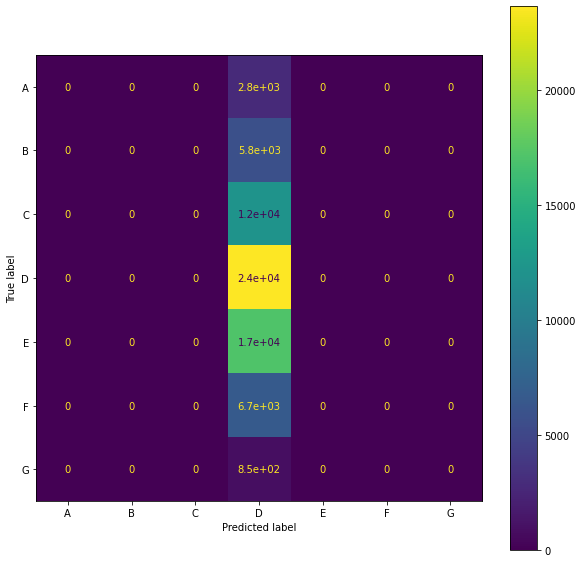

time: 5.26 s (started: 2021-05-27 12:18:57 +00:00)


In [26]:
# Init MLflow client
mlflow.set_experiment('DPE-Mean')

params = Parameters()

# Start MLflow experiment
with mlflow.start_run(run_name='Baseline : Mean') as run:
    # Pipeline execution
    pipeline = Pipeline(params)
    pipeline.load_dataset()
    pipeline.preprocessing()
    pipeline.train_test_split() 
    pipeline.model()  
    pipeline.model_evaluation()
    pipeline.log_confusion_metrics()
    pipeline.save_plot()

In [ ]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "1sCdZL0vOhPokZP6r1uZFcIG2B5_2AGxAFTUesCxw3MDWPEdw"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [ ]:
!mlflow ui

# Decision Tree Regressor


* The only categorical varibale we have is ***'code departement'*** (zip code).

* The column is already an int. We could encode it into dummy variables but that woud generate 96 more columns which is not ideal for tree based models.
We tried label encoding but it makes no sense business wise. Se we settled for frequency encoding.

In [30]:
class Parameters:
    # Preprocessing parameters
    data_name: str = f"DPE"
    data_path: str = f"/content/drive/My Drive/MVP/DPE/datasets/dpe_enriched.csv"
    img_path: str = f"/content/drive/My Drive/MVP/DPE/images"
    model_path: str = f"/content/drive/My Drive/MVP/DPE/models"
    model_name: str = f"decision_trees"
    k_folds: int = 10 
    test_size: float = 0.25
    random_state = int = 42

time: 4.42 ms (started: 2021-05-27 12:19:56 +00:00)


In [31]:
class Pipeline:
    """
    Class that builds entire ML pipeline and saves it to MLflow.
    """

    def __init__(self, parameters):
        """
        Init pipeline with datasets, model parameters and performance measurements. 
        """
        self.params = parameters
        self.dataset_path = params.data_path
        self.dataset = None

        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_test_class = None
        self.y_pred = None # Consommation energie
        self.y_pred_class = None # Classe consommation energie

        self.best_max_depth = None
        self.best_min_samples_split = None
        self.min_samples_leaf = None
        self.min_weight_fraction_leaf = None
        self.max_features = None
        self.max_leaf_nodes = None
        self.best_grid = None
        self.best_splitter = None
        self.tree = None

        self.classes = ['A','B','C','D','E','F','G']
        self.confusion_matrix = None
        self.classification_metrics = None


    def load_dataset(self):
        """
        Load dataset into a pandas dataframe.
        """
        self.dataset = pd.read_csv(self.dataset_path, decimal='.', low_memory=False, index_col=0)


    def preprocessing(self):
        """
        Preprocessing dataset, includes encoding categorical features using a frequency encoder,
        dropping useless features and selecting the target.
        """
        encoding = self.dataset.groupby('code_departement').size()
        encoding = encoding/len(self.dataset)
        self.dataset['code_departement'] = self.dataset.code_departement.map(encoding)


        self.X = self.dataset.drop(['consommation_energie','estimation_ges', 'classe_consommation_ges',
                            'date_visite_diagnostiqueur', 'date_etablissement_dpe','energie_totale',
                            'code_region','code_insee_commune_actualise',
                            'annee_construction','classe_estimation_ges','annee_visite'],axis = 1)

        self.y = self.dataset['consommation_energie']


    def train_test_split(self):
        """
        Split data into train and test sets.
        """
        # Use stratify to make sure we get an equal distribution of energy classes over the data sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,self.y, test_size=self.params.test_size, 
                                                                                random_state=self.params.random_state, 
                                                                                stratify=self.X['classe_consommation_energie'])

        self.X_train = self.X_train.drop(['classe_consommation_energie'], axis = 1)
        self.X_test = self.X_test.drop(['classe_consommation_energie'], axis = 1)


    def parameter_tuning(self):
        """
        Hyperparameter tuning using grid search.
        """
        # Grid parameters 
        params = {
                'max_depth': [5, 8, 10],
                'min_samples_split' : [10, 100],
                'min_samples_leaf':[1,2],
                'min_weight_fraction_leaf':[0.0, 0.1],
                'max_features':["auto","log2","sqrt",None],
                'max_leaf_nodes':[None,10], 
                'criterion': ['mse'], 
                'splitter':["best"],
                }

        # Grid search
        tree = DecisionTreeRegressor()
        grid = GridSearchCV(tree, params, cv=self.params.k_folds)
        grid.fit(self.X_train, self.y_train)

        # Assign the best parameters
        self.best_max_depth = grid.best_params_['max_depth']
        self.best_min_samples_split = grid.best_params_['min_samples_split']
        self.best_max_leaf_nodes = grid.best_params_['max_leaf_nodes']
        self.best_max_features = grid.best_params_['max_features']
        self.best_min_weight_fraction_leaf = grid.best_params_['min_weight_fraction_leaf']
        self.best_min_samples_leaf = grid.best_params_['min_samples_leaf']
        self.best_criterion = grid.best_params_['criterion'] 
        self.best_splitter = grid.best_params_['splitter']
            
        # Log the best parameters to Mlflow
        mlflow.log_param(f'best_max_depth', self.best_max_depth) 
        mlflow.log_param(f'best_min_samples_split', self.best_min_samples_split)
        mlflow.log_param(f'best_max_leaf_nodes', self.best_max_leaf_nodes)
        mlflow.log_param(f'best_max_features', self.best_max_features)
        mlflow.log_param(f'best_min_weight_fraction_leaf', self.best_min_weight_fraction_leaf)
        mlflow.log_param(f'best_min_samples_leaf', self.best_min_samples_leaf)
        mlflow.log_param(f'best_criterion', self.best_criterion)
        mlflow.log_param(f'best_splitter', self.best_splitter)

      
    def k_fold_cross_validation(self):
        """
        Apply k-fold cross validation.
        """
        self.tree = DecisionTreeRegressor(max_depth=self.best_max_depth, min_samples_split=self.best_min_samples_split,
                                        splitter=self.best_splitter, criterion=self.best_criterion)
        kfold_scores = cross_val_score(self.tree, self.X_train, self.y_train, cv=self.params.k_folds)

        # Log accuracy metrics to MLflow 
        mlflow.log_metric(f"average_accuracy", kfold_scores.mean())
        mlflow.log_metric(f"std_accuracy", kfold_scores.std())


    def model_evaluation(self):
        """
        Evaluate model using classification metrics by converting energy consumption (regression) to classes.
        And log metrics to MLflow.
        """
        # Assign classes to test target
        c = self.y_test.copy() 
        conditions = [(c >= 0) & (c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_test_class = np.select(conditions,self.classes)

        # Fit model
        self.tree.fit(self.X_train, self.y_train) 
        self.y_pred = self.tree.predict(self.X_test)

        # Assign classes to predicted target
        c = self.y_pred.copy()
        conditions = [(c >= 0) & (c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_pred_class = np.select(conditions,self.classes)

        # Compute classification report
        self.classification_metrics = metrics.classification_report(self.y_test_class, self.y_pred_class)
        self.confusion_matrix = metrics.confusion_matrix(self.y_test_class, self.y_pred_class)

        # Log accuracy to MLflow
        mlflow.log_metric(f"train_accuracy", self.tree.score(self.X_train, self.y_train))
        mlflow.log_metric(f"test_accuracy", self.tree.score(self.X_test, self.y_test))
 

    def log_confusion_metrics(self):
        """
        Log classification report metrics to MLflow.
        """
        classification_array = self.classification_metrics.split()

        i = 5
        for classe in self.classes:
            precision = float(classification_array[i])
            mlflow.log_metric(f"precision_{classe}", precision)

            recall = float(classification_array[i+1])
            mlflow.log_metric(f"recall_{classe}", recall)

            f1_score = float(classification_array[i+2])
            mlflow.log_metric(f"f1-score_{classe}", f1_score)

            support = float(classification_array[i+3])
            mlflow.log_metric(f"support_{classe}", support)

            i = i+5

        accuracy = float(classification_array[i])
        mlflow.log_metric("accuracy", accuracy)


    def save_model(self):
        """
        Save model and performance plots.
        """
        # Track confusion matrix plot
        fig, axes = plt.subplots(figsize=(10,10))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix, display_labels=self.classes)
        disp = disp.plot(ax=axes)
        plt.savefig(f"{self.params.img_path}/confusion_matrix_{self.params.model_name}.png")
        # Log plot
        mlflow.log_artifact(f"{self.params.img_path}/confusion_matrix_{self.params.model_name}.png")

        # Feature Importance
        explainer = shap.TreeExplainer(self.tree)
        shap_values = explainer.shap_values(self.X_test)

        fig, axes = plt.subplots(figsize=(10,10))
        shap.summary_plot(shap_values, self.X_test, show=False)
        plt.savefig(f"{pipeline.params.img_path}/feature_importance_{self.params.model_name}.png", dpi=150, bbox_inches='tight')

        fig, axes = plt.subplots(figsize=(10,10))
        shap.summary_plot(shap_values, self.X_test, plot_type='bar', show=False)
        plt.savefig(f"{pipeline.params.img_path}/feature_importance_bar_{self.params.model_name}.png", dpi=150, bbox_inches='tight')

        # Log the best model
        mlflow.sklearn.save_model(self.tree, f"{self.params.model_path}/_{self.params.model_name}", serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE) 

time: 392 ms (started: 2021-05-27 12:22:08 +00:00)


MlflowException: ignored

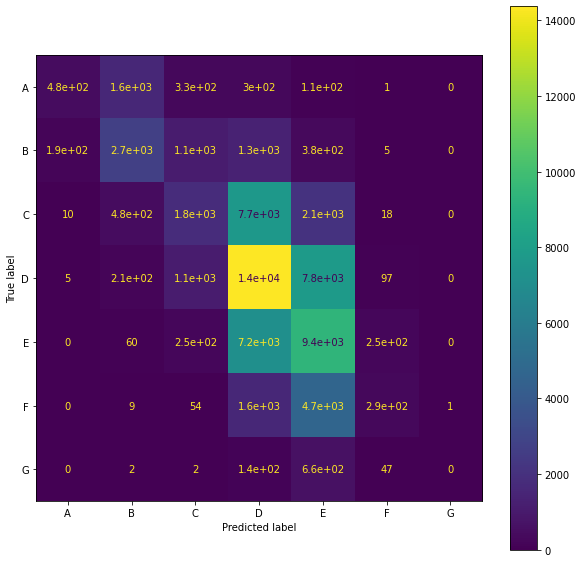

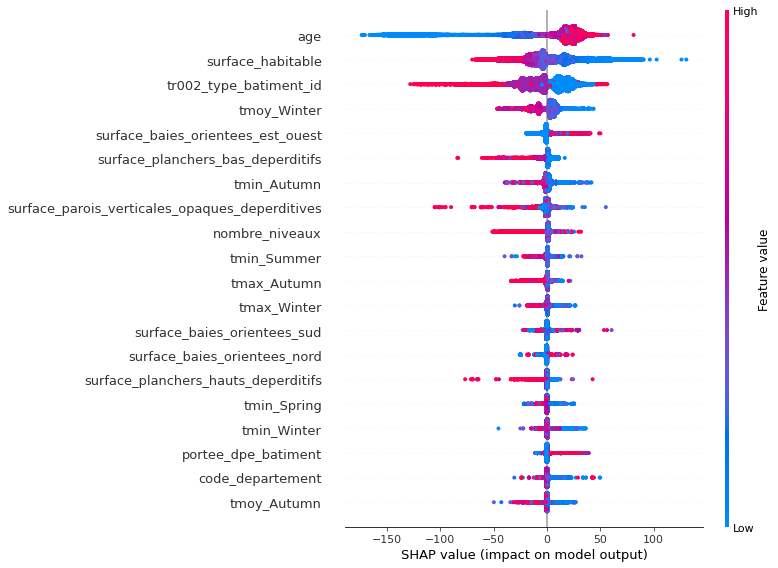

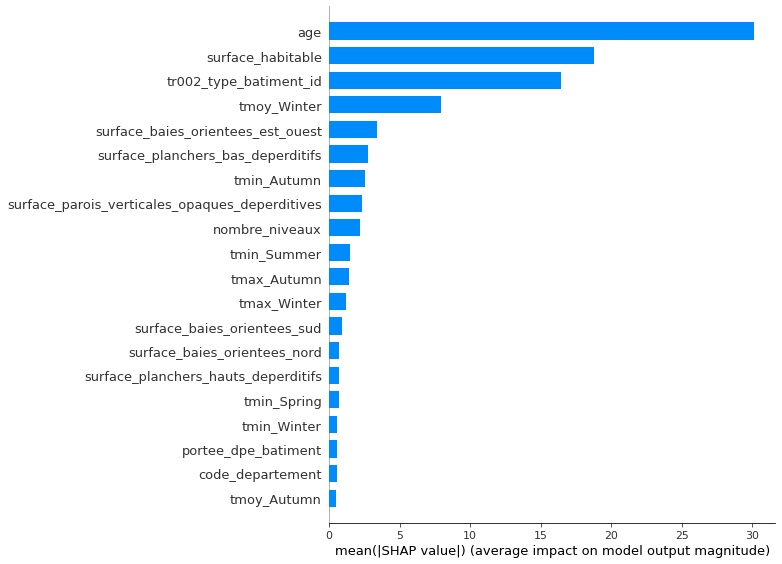

time: 20min 25s (started: 2021-05-27 12:22:12 +00:00)


In [32]:
# Init MLflow client
mlflow.set_experiment('DPE-Decision-Trees')

params = Parameters()

# Start MLflow experiment
with mlflow.start_run(run_name='Decision Tree Regression') as run:
    # Pipeline execution
    pipeline = Pipeline(params)
    pipeline.load_dataset()
    pipeline.preprocessing()
    pipeline.train_test_split()
    pipeline.parameter_tuning()
    pipeline.k_fold_cross_validation()
    pipeline.model_evaluation()
    pipeline.log_confusion_metrics()
    pipeline.save_model()

In [ ]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "1sCdZL0vOhPokZP6r1uZFcIG2B5_2AGxAFTUesCxw3MDWPEdw"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://b10a1d9c4abe.ngrok.io
time: 1.48 s (started: 2021-05-07 09:24:55 +00:00)


In [ ]:
!mlflow ui

[2021-05-07 09:24:59 +0000] [578] [INFO] Starting gunicorn 20.1.0
[2021-05-07 09:24:59 +0000] [578] [INFO] Listening at: http://127.0.0.1:5000 (578)
[2021-05-07 09:24:59 +0000] [578] [INFO] Using worker: sync
[2021-05-07 09:24:59 +0000] [581] [INFO] Booting worker with pid: 581
[2021-05-07 09:33:02 +0000] [578] [INFO] Handling signal: int

Aborted!
[2021-05-07 09:33:02 +0000] [581] [INFO] Worker exiting (pid: 581)
[2021-05-07 09:33:02 +0000] [578] [INFO] Shutting down: Master
time: 8min 5s (started: 2021-05-07 09:24:57 +00:00)


# LightGBM

* **Light GBM** is a gradient boosting framework that uses tree based learning algorithm.


* Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise.


* We chose LightGBM because of its high speed, because it can handle large datasets and it takes lower memory to run. It also focuses on accuracy of results.


* For hyperparameter tuning, we chose a **Bayesian hyperparameter Optimization** approach which builds a probability model of the objective function and uses it to select the most promising hyperparameters to evaluate in the true objective function. Here we use gaussian process-based optimisation.

* Let's start by splitting the train set into a train set and a validation set. We don't use the test set in the hyper-parameter optimization to avoid any leak :

In [33]:
class Parameters:
    # Preprocessing parameters
    data_name: str =f"DPE"
    model_name: str = f"LightGBM"
    data_path: str = f"/content/drive/My Drive/MVP/DPE/datasets/dpe_enriched.csv"
    img_path: str = f"/content/drive/My Drive/MVP/DPE/images"
    model_path: str = f"/content/drive/My Drive/MVP/DPE/models"
    k_folds: int = 10 # K-folds cross validation
    test_size: float = 0.25 # Test data size
    random_state: int = 42

time: 4.93 ms (started: 2021-05-27 12:49:20 +00:00)


In [34]:
class Pipeline:
    """
    Class that builds entire ML pipeline and saves it to MLflow.
    """

    def __init__(self, parameters):
        """
        Init pipeline with datasets, model parameters and performance measurements. 
        """
        self.params = parameters
        self.dataset_path = params.data_path
        self.dataset = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_test_class = None
        self.y_pred = None
        self.y_pred_class = None

        self.classes = ['A','B','C','D','E','F','G']

        self.cat_features = None
        self.best_metric = None
        self.best_n_estimators = None
        self.num_leaves = None
        self.learning_rate = None
        self.boosting_type = None
        self.best_max_depth = None
        self.gbm = None

        self.confusion_matrix = None
        self.classification_metrics = None


    def load_dataset(self):
        """
        Load dataset into a pandas dataframe.
        """
        self.dataset = pd.read_csv(self.dataset_path, decimal='.', low_memory=False, index_col=0)


    def preprocessing(self):
        """
        Preprocessing dataset, includes casting categorical features,
        dropping useless features and selecting the target.
        """
        self.dataset['code_departement'] = self.dataset['code_departement'].astype('category')
        self.X = self.dataset.drop(['consommation_energie','estimation_ges', 'classe_consommation_ges',
                            'date_visite_diagnostiqueur', 'date_etablissement_dpe','energie_totale',
                            'code_region','code_insee_commune_actualise',
                            'annee_construction','classe_estimation_ges','annee_visite'],axis = 1)

        self.y = self.dataset['consommation_energie']


    def train_test_split(self):
        """
        Split data into train and test sets.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,self.y, test_size=self.params.test_size,
                                                                                random_state=self.params.random_state,
                                                                                stratify=self.X['classe_consommation_energie'])
        self.X_train = self.X_train.drop(['classe_consommation_energie'], axis = 1)
        self.X_test = self.X_test.drop(['classe_consommation_energie'], axis = 1)


    def parameter_tuning(self):
        """
        Hyperparameter tuning using grid search.
        """
        # Assign categorical features
        self.cat_features = ['code_departement', 'tr002_type_batiment_id']

        # Parameters 
        params = {
                'task': ['train'],
                'boosting_type': ['gbdt'],#, 'rf'
                'objective': ['regression'],
                'metric': ['l2'],#auc
                'learning_rate': [0.005], #0.01
                'feature_fraction': [0.9],
                'bagging_fraction': [0.7],
                'bagging_freq': [10],
                'verbose': [0],
                'max_depth': [8, 10], #10, 12, 25
                'num_leaves': [128], #128, 250 
                'max_bin': [512],
                #"num_iterations": [100000],
                'n_estimators': [500], # 600
                'is_training_metric' : ['True']
                }

        # Grid search
        gbm = lgb.LGBMRegressor()
        grid = GridSearchCV(gbm, params, cv=self.params.k_folds)
        grid.fit(self.X_train, self.y_train, categorical_feature=self.cat_features)

        # Assign the best parameters
        self.best_metric = grid.best_params_['metric']
        self.best_boosting_type = grid.best_params_['boosting_type']
        self.best_num_leaves = grid.best_params_['num_leaves']
        self.best_learning_rate = grid.best_params_['learning_rate']
        self.best_n_estimators = grid.best_params_['n_estimators']
        self.best_max_depth = grid.best_params_['max_depth']

        # Log the best parameters    
        mlflow.log_param(f'best_metric', self.best_metric)
        mlflow.log_param(f'best_boosting_type', self.best_boosting_type)
        mlflow.log_param(f'best_num_leaves', self.best_num_leaves)
        mlflow.log_param(f'best_learning_rate', self.best_learning_rate)
        mlflow.log_param(f'best_n_estimators', self.best_n_estimators)
        mlflow.log_param(f'best_max_depth', self.best_max_depth)

        
    def k_fold_cross_validation(self):
        """
        Apply k-fold cross validation.
        """
        self.gbm = lgb.LGBMRegressor(metric=self.best_metric, n_estimators=self.best_n_estimators, num_leaves=self.num_leaves,
                                    boosting_type=self.boosting_type, learning_rate=self.learning_rate)
        kfold_scores = cross_val_score(self.gbm, self.X_train, self.y_train, cv=self.params.k_folds)

        # Log accuracy metrics to MLflow 
        mlflow.log_metric(f"average_accuracy", kfold_scores.mean())
        mlflow.log_metric(f"std_accuracy", kfold_scores.std())


    def model_evaluation(self):
        """
        Evaluate model using classification metrics by converting energy consumption (regression) to classes.
        And log metrics to MLflow.
        """
        # Assign classes to test target
        c = self.y_test.copy() 
        conditions = [(c <= 50 ), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_test_class = np.select(conditions, self.classes)

        # Fit model
        self.gbm.fit(self.X_train, self.y_train, categorical_feature=self.cat_features)
        self.y_pred = self.gbm.predict(self.X_test)

        # Assign classes to predicted target
        c = self.y_pred.copy()
        conditions = [(c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_pred_class = np.select(conditions, self.classes)

        # Compute classification report
        self.classification_metrics = metrics.classification_report(self.y_test_class, self.y_pred_class)
        self.confusion_matrix = metrics.confusion_matrix(self.y_test_class, self.y_pred_class)

        # Log accuracy to MLflow
        #mlflow.log_metric(f"train_accuracy", self.tree.score(self.X_train, self.y_train))
        #mlflow.log_metric(f"test_accuracy", self.tree.score(self.X_test, self.y_test))
    

    def log_confusion_metrics(self):
        """
        Log classification report metrics to MLflow.
        """
        classification_array = self.classification_metrics.split()

        i = 5
        for classe in self.classes:
            precision = float(classification_array[i])
            mlflow.log_metric(f"precision_{classe}", precision)

            recall = float(classification_array[i+1])
            mlflow.log_metric(f"recall_{classe}", recall)

            f1_score = float(classification_array[i+2])
            mlflow.log_metric(f"f1-score_{classe}", f1_score)

            support = float(classification_array[i+3])
            mlflow.log_metric(f"support_{classe}", support)

            i = i+5

        accuracy = float(classification_array[i])
        mlflow.log_metric("accuracy", accuracy)
      

    def save_model(self):
        """
        Save model and performance plots.
        """
        # Track confusion matrix plot
        fig, axes = plt.subplots(figsize=(10,10))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix, display_labels=self.classes)
        disp = disp.plot(ax=axes)
        plt.savefig(f"{self.params.img_path}/confusion_matrix_{self.params.model_name}.png")
        # Log plot
        mlflow.log_artifact(f"{self.params.img_path}/confusion_matrix_{self.params.model_name}.png")

        # Feature Importance
        explainer = shap.TreeExplainer(self.gbm)
        shap_values = explainer.shap_values(self.X_test)

        fig, axes = plt.subplots(figsize=(10,10))
        shap.summary_plot(shap_values, self.X_test, show=False)
        plt.savefig(f"{pipeline.params.img_path}/feature_importance_{self.params.model_name}.png", dpi=150, bbox_inches='tight')

        fig, axes = plt.subplots(figsize=(10,10))
        shap.summary_plot(shap_values, self.X_test, plot_type='bar', show=False)
        plt.savefig(f"{pipeline.params.img_path}/feature_importance_bar_{self.params.model_name}.png", dpi=150, bbox_inches='tight')

        # Log the best model
        mlflow.sklearn.save_model(self.gbm, f"{self.params.model_path}/_{self.params.model_name}", serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

time: 397 ms (started: 2021-05-27 12:49:22 +00:00)


In [ ]:
# Init MLflow client
mlflow.set_experiment('DPE-LightGBM')

params = Parameters()

# Start MLflow experiment
with mlflow.start_run(run_name='LightGBM') as run:
    #Pipeline execution
    pipeline = Pipeline(params)
    pipeline.load_dataset()
    pipeline.preprocessing()
    pipeline.train_test_split()
    pipeline.parameter_tuning()
    pipeline.k_fold_cross_validation()
    pipeline.model_evaluation()
    pipeline.log_confusion_metrics()
    pipeline.save_model()

In [ ]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://41f92b8a3ad3.ngrok.io
time: 298 ms (started: 2021-05-10 14:44:40 +00:00)


In [ ]:
!mlflow ui

[2021-05-10 14:44:43 +0000] [2102] [INFO] Starting gunicorn 20.1.0
[2021-05-10 14:44:43 +0000] [2102] [INFO] Listening at: http://127.0.0.1:5000 (2102)
[2021-05-10 14:44:43 +0000] [2102] [INFO] Using worker: sync
[2021-05-10 14:44:43 +0000] [2105] [INFO] Booting worker with pid: 2105
[2021-05-10 14:45:26 +0000] [2102] [INFO] Handling signal: int

Aborted!
[2021-05-10 14:45:27 +0000] [2105] [INFO] Worker exiting (pid: 2105)
[2021-05-10 14:45:27 +0000] [2102] [INFO] Shutting down: Master
time: 46 s (started: 2021-05-10 14:44:41 +00:00)


# Catboost

In [ ]:
class Parameters:
    # Preprocessing parameters
    data_name: str =f"DPE"
    data_path: str = f"/content/drive/My Drive/MVP/DPE/datasets/dpe_enriched.csv"
    img_path: str = f"/content/drive/My Drive/MVP/DPE/images"
    model_path: str = f"/content/drive/My Drive/MVP/DPE/models"
    model_name: str = f"CatBoost"
    k_folds: int = 10 # K-folds cross validation
    test_size: float = 0.25 # Test data size
    random_state: int = 42

time: 6.05 ms (started: 2021-05-10 14:45:29 +00:00)


In [ ]:
class Pipeline:
    """
    Class that builds entire ML pipeline and saves it to MLflow.
    """

    def __init__(self, parameters):
        """
        Init pipeline with datasets, model parameters and performance measurements. 
        """
        self.params = parameters
        self.dataset_path = params.data_path
        self.dataset = None

        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_test_class = None
        self.y_pred = None
        self.y_pred_class = None
        self.cat_features = None

        self.best_iterations = None
        self.best_depth = None
        self.learning_rate = None
        self.num_leaves = None
        self.boosting_type = None
        self.best_max_depth = None
        self.cgb = None

        self.classes = ['A','B','C','D','E','F','G']
        self.confusion_matrix = None
        self.classification_metrics = None


    def load_dataset(self):
        """
        Load dataset into a pandas dataframe.
        """
        self.dataset = pd.read_csv(self.dataset_path, decimal='.', low_memory=False, index_col=0)


    def preprocessing(self):
        """
        Preprocessing dataset, includes 
        dropping useless features and selecting the target.
        """
        self.X = self.dataset.drop(['consommation_energie','estimation_ges', 'classe_consommation_ges',
                            'date_visite_diagnostiqueur', 'date_etablissement_dpe','energie_totale',
                            'code_region','code_insee_commune_actualise',
                            'annee_construction','classe_estimation_ges','annee_visite'],axis = 1)

        self.y = self.dataset['consommation_energie']


    def train_test_split(self):
        """
        Split data into train and test sets.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,self.y, test_size=self.params.test_size,
                                                                                random_state=self.params.random_state,
                                                                                stratify=self.X['classe_consommation_energie'])
        self.X_train = self.X_train.drop(['classe_consommation_energie'], axis = 1)
        self.X_test = self.X_test.drop(['classe_consommation_energie'], axis = 1)


    def parameter_tuning(self):
        """
        Hyperparameter tuning using grid search.
        """
        # Assign categorical features
        self.cat_features = ['code_departement']

        # Parameters 
        params = {
                'iterations': [100, 500],#500
                'learning_rate': [0.005],#, 0.01, 1
                'depth': [8, 10, 12] #, 10, 12, 25
                }
  
        # Grid search  
        self.cgb = cgb.CatBoostRegressor(silent=True)
        grid = GridSearchCV(self.cgb, params, cv=self.params.k_folds)
        grid.fit(self.X_train, self.y_train, cat_features=self.cat_features)

        # Assign the best parameters
        self.best_metric = grid.best_params_['iterations']
        self.best_boosting_type = grid.best_params_['learning_rate']
        self.best_learning_rate = grid.best_params_['learning_rate']
        #self.best_num_leaves = grid.best_params_['num_leaves']
        #self.best_n_estimators = grid.best_params_['n_estimators']
        #self.best_max_depth = grid.best_params_['max_depth']

        # Log the best parameters   
        mlflow.log_param(f'best_iterations', self.best_iterations)
        mlflow.log_param(f'best_learning_rate', self.best_learning_rate)
        mlflow.log_param(f'best_depth', self.best_depth)
        #mlflow.log_param(f'best_learning_rate', self.best_learning_rate)
        #mlflow.log_param(f'best_n_estimators', self.best_n_estimators)
        #mlflow.log_param(f'best_max_depth', self.best_max_depth)

      
    def k_fold_cross_validation(self):
        """
        Apply k-fold cross validation.
        """
        self.cgb = cgb.CatBoostRegressor(depth=self.best_depth, iterations=self.best_iterations, learning_rate=self.learning_rate)
        kfold_scores = cross_val_score(self.cgb, self.X_train, self.y_train, cv=self.params.k_folds)

        # Log accuracy metrics to MLflow 
        mlflow.log_metric(f"average_accuracy", kfold_scores.mean())
        mlflow.log_metric(f"std_accuracy", kfold_scores.std())


    def model_evaluation(self):
        """
        Evaluate model using classification metrics by converting energy consumption (regression) to classes.
        And log metrics to MLflow.
        """
        # Assign classes to test target
        c = self.y_test.copy() 
        conditions = [(c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_test_class = np.select(conditions, self.classes)

        # Fit model
        self.cgb.fit(self.X_train, self.y_train, cat_features=self.cat_features)
        self.y_pred = self.cgb.predict(self.X_test)

        # Assign classes to predicted target
        c = self.y_pred.copy()
        conditions = [(c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_pred_class = np.select(conditions, self.classes)

        # Compute classification report
        self.classification_metrics = metrics.classification_report(self.y_test_class, self.y_pred_class)
        self.confusion_matrix = metrics.confusion_matrix(self.y_test_class, self.y_pred_class)

        # Log accuracy to MLflow
        #mlflow.log_metric(f"train_accuracy", self.tree.score(self.X_train, self.y_train))
        #mlflow.log_metric(f"test_accuracy", self.tree.score(self.X_test, self.y_test))


    def log_confusion_metrics(self):
        """
        Log classification report metrics to MLflow.
        """
        classification_array = self.classification_metrics.split()

        i = 5
        for classe in self.classes:
            precision = float(classification_array[i])
            mlflow.log_metric(f"precision_{classe}", precision)

            recall = float(classification_array[i+1])
            mlflow.log_metric(f"recall_{classe}", recall)

            f1_score = float(classification_array[i+2])
            mlflow.log_metric(f"f1-score_{classe}", f1_score)

            support = float(classification_array[i+3])
            mlflow.log_metric(f"support_{classe}", support)

            i = i+5

        accuracy = float(classification_array[i])
        mlflow.log_metric("accuracy", accuracy)
    

    def save_model(self):
        """
        Save model and performance plots.
        """
        # Track confusion matrix plot
        fig, axes = plt.subplots(figsize=(10,10))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix, display_labels=self.classes)
        disp = disp.plot(ax=axes)
        plt.savefig(f"{self.params.img_path}/confusion_matrix_{self.params.model_name}.png")
        # Log plot
        mlflow.log_artifact(f"{self.params.img_path}/confusion_matrix_{self.params.model_name}.png")

        # Feature Importance
        explainer = shap.TreeExplainer(self.cgb)
        shap_values = explainer.shap_values(self.X_test)

        fig, axes = plt.subplots(figsize=(10,10))
        shap.summary_plot(shap_values, self.X_test, show=False)
        plt.savefig(f"{pipeline.params.img_path}/feature_importance_{self.params.model_name}.png", dpi=150, bbox_inches='tight')

        fig, axes = plt.subplots(figsize=(10,10))
        shap.summary_plot(shap_values, self.X_test, plot_type='bar', show=False)
        plt.savefig(f"{pipeline.params.img_path}/feature_importance_bar_{self.params.model_name}.png", dpi=150, bbox_inches='tight')

        # Track the best model
        mlflow.sklearn.save_model(self.cgb, f"{self.params.model_path}/_{self.params.model_name}", serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

In [ ]:
# Init MLflow client
mlflow.set_experiment('DPE-CatBoost')

params = Parameters()

# Start MLflow experiment
with mlflow.start_run(run_name='CatBoost') as run:
    #Pipeline execution
    pipeline = Pipeline(params)
    pipeline.load_dataset()
    pipeline.preprocessing()
    pipeline.train_test_split()
    pipeline.parameter_tuning()
    pipeline.k_fold_cross_validation()
    pipeline.model_evaluation()
    pipeline.log_confusion_metrics()
    pipeline.save_model()

In [ ]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "1sCdZL0vOhPokZP6r1uZFcIG2B5_2AGxAFTUesCxw3MDWPEdw"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://9abbd83b359e.ngrok.io
time: 408 ms (started: 2021-05-10 16:36:36 +00:00)


In [ ]:
!mlflow ui

t=2021-05-10T16:36:39+0000 lvl=warn msg="failed to open private leg" id=3439d95d70e9 privaddr=localhost:5000 err="dial tcp 127.0.0.1:5000: connect: connection refused"


[2021-05-10 16:36:39 +0000] [2854] [INFO] Starting gunicorn 20.1.0
[2021-05-10 16:36:39 +0000] [2854] [INFO] Listening at: http://127.0.0.1:5000 (2854)
[2021-05-10 16:36:39 +0000] [2854] [INFO] Using worker: sync
[2021-05-10 16:36:39 +0000] [2857] [INFO] Booting worker with pid: 2857
[2021-05-10 16:36:58 +0000] [2854] [INFO] Handling signal: int
[2021-05-10 16:36:59 +0000] [2857] [INFO] Worker exiting (pid: 2857)

Aborted!
[2021-05-10 16:36:59 +0000] [2854] [INFO] Shutting down: Master
time: 22.1 s (started: 2021-05-10 16:36:37 +00:00)


# Save mlruns to drive

In [ ]:
!zip -r /content/mlruns.zip  /content/mlruns

In [ ]:
shutil.move("/content/mlruns", "/content/drive/MyDrive/MVP/DPE/mlflow/mlruns")

'/content/drive/MyDrive/MVP/DPE/mlflow/mlruns'

time: 3.83 s (started: 2021-05-10 16:32:14 +00:00)
